In [72]:
import pandas as pd
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import sklearn.preprocessing as pre
from pandas import DataFrame
from pandas import concat
from scipy.stats import linregress as lr
from scipy.signal import find_peaks as find_peaks
from scipy.fftpack import fft, ifft,rfft
from sklearn.decomposition import PCA

# 0. Preprocessing and Reading Data

In [73]:
patient = 3
cgmSeries = pd.read_csv("DataFolder/CGMDatenumLunchPat" + str(patient) + ".csv")
cgmData = pd.read_csv("DataFolder/CGMSeriesLunchPat" + str(patient) + ".csv")
cgmData = cgmData.mask(cgmData.eq(-1)).ffill(axis=1)
insulinBasal = pd.read_csv("DataFolder/InsulinBasalLunchPat" + str(patient) + ".csv")
insulinBasal = insulinBasal.fillna(0)
insulinBolus = pd.read_csv("DataFolder/InsulinBolusLunchPat" + str(patient) + ".csv")
insulinBolus = insulinBolus.fillna(0)
insulinTime = pd.read_csv("DataFolder/InsulinDatenumLunchPat" + str(patient) + ".csv")

# Remove Empty Rows
zero_entries = cgmData.isna().any(axis=1)
cgmData = cgmData[zero_entries == False]

cgmSeries = cgmSeries[zero_entries == False]
insulinBasal = insulinBasal[zero_entries == False]
insulinBolus = insulinBolus[zero_entries == False]
insulinTime = insulinTime[zero_entries == False]

In [74]:
reading_no = 1
# Normalize CGMValues
cgmValues_np = cgmData.values
cgmNorm_np = pre.minmax_scale(cgmValues_np, axis=1)

# CGM Timeseries
cgmSeries_np = cgmSeries.values
timeMins = np.nanmin(cgmSeries_np, axis=1)
cgmSeries_np = cgmSeries_np - timeMins[:, None]

# Normalize insulinBasal
insulinBasal_np = insulinBasal.values
insulinBasalNorm_np = pre.minmax_scale(insulinBasal_np, axis=1)

# Normalize insulinBolus
insulinBolus_np = insulinBolus.values
insulinBolusNorm_np = pre.minmax_scale(insulinBolus_np, axis=1)

# Insluin Timeseries
insulinTime_np = insulinTime.values - timeMins[:, None]

# 1.a Anirudh Features

In [75]:
# Slope between max and min
maxs = np.argmax(cgmNorm_np, axis=1)
mins = [np.argmin(cgmNorm_np[i, maxs[i]:])+maxs[i] for i in range(len(maxs))]

slopes = []
time_diffs = []
for i in range(len(maxs)):
    slope = (cgmNorm_np[i][maxs[i]]-cgmNorm_np[i][mins[i]])/(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    time_diffs.append(cgmSeries_np[i][maxs[i]]-cgmSeries_np[i][mins[i]])
    slopes.append(slope)
    
slopes = np.nan_to_num(slopes)
time_diffs = np.nan_to_num(time_diffs)

/home/anikl9705/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


In [76]:
# Regression Error
reg_window_size = 4
reg_errors = []
peak_values = []
peak_heights = []
peak_time_diffs = []
peak_times = []
for j in range(len(cgmNorm_np)):
    errors = np.array([])
    for i in range(len(cgmNorm_np[j])-reg_window_size):
        times = cgmSeries_np[j][i:i+reg_window_size-1]
        coeffs = np.polyfit(times, cgmNorm_np[j][i:i+reg_window_size-1], 1)
        poly = np.poly1d(coeffs)
        error = poly(cgmSeries_np[j][i+reg_window_size])-cgmNorm_np[j][i+reg_window_size];
        errors = np.append(errors, error)
    peaks, height_dict = find_peaks(errors, height = 0)
    heights = height_dict['peak_heights']
    sorted_args = heights.argsort()
    peaks = peaks[sorted_args]
    peaks = peaks[-2:]
    heights = heights[sorted_args]
    heights = heights[-2:]
    values = cgmNorm_np[j][peaks+reg_window_size-1]
    times = cgmSeries_np[j][peaks+reg_window_size]
    times2 = cgmSeries_np[j][peaks+reg_window_size-1]
    reg_errors.append(errors)
    while(len(values) < 2):
        values = np.append(values, 0)
        heights = np.append(heights, 0)
        times = np.append(times, 0)
        times2 = np.append(times2, 0)
    peak_values.append(values)
    peak_heights.append(heights)
    peak_time_diffs.append(times)
    peak_times.append(times2)
reg_errors = np.array(reg_errors)

28.800000171661384
0.03472222201526165


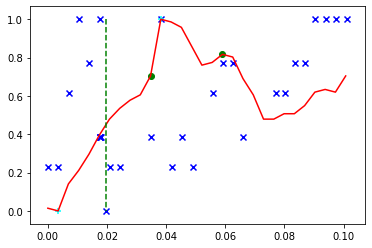

[0.81690141 0.70422535]
[0.22065731 0.43896713]
[0.05902778 0.03472222]


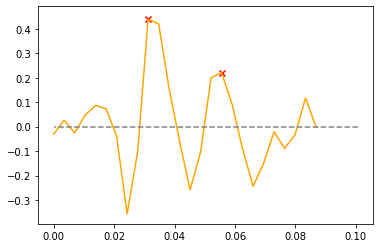

22.153846560145276
0.0451388880610466


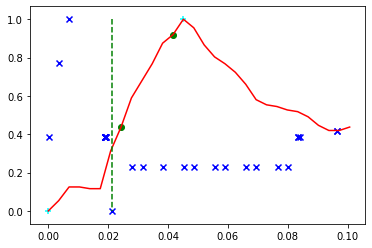

[0.4375     0.91964286]
[0.09821431 0.26636903]
[0.02430556 0.04166667]


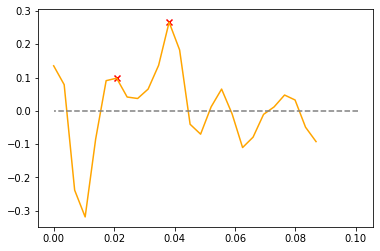

12.387096721455794
0.07291666697710752


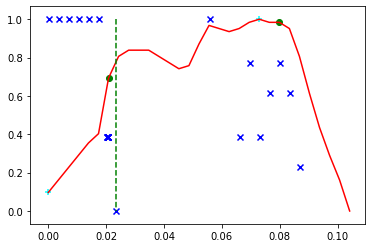

[0.98387097 0.69354839]
[0.31451619 0.37634409]
[0.07986111 0.02083333]


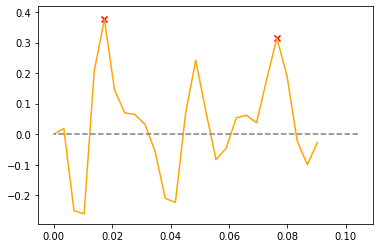

35.95505615569564
0.02781250001862645


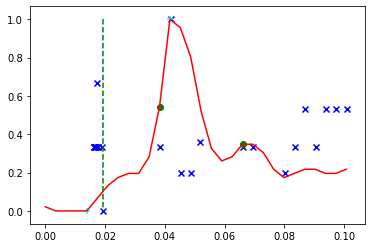

[0.34782609 0.54347826]
[0.20289853 0.93115945]
[0.06600694 0.03822917]


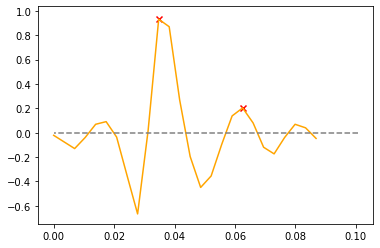

15.157894784393733
0.06597222201526165


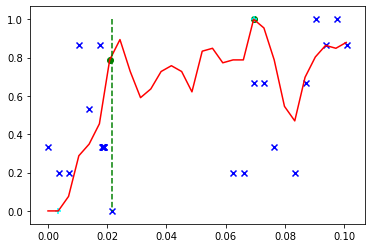

[1.         0.78787879]
[0.5883839 0.7373737]
[0.06944444 0.02083333]


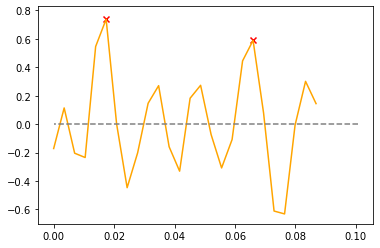

0.0
0.0


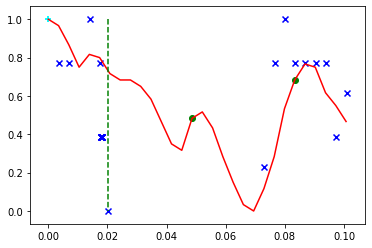

[0.68333333 0.48333333]
[0.40277779 0.44444441]
[0.08333333 0.04861111]


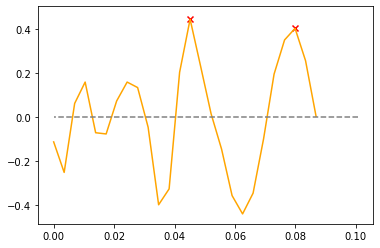

29.69072167713618
0.013888888875953853


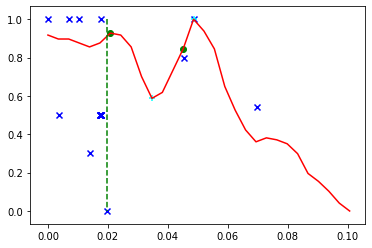

[0.92783505 0.84536082]
[0.27319591 0.42783502]
[0.02083333 0.04513889]


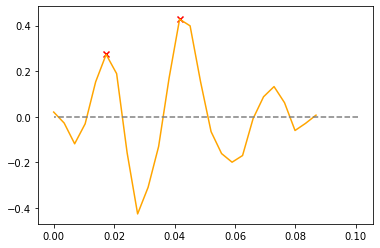

0.0
0.0


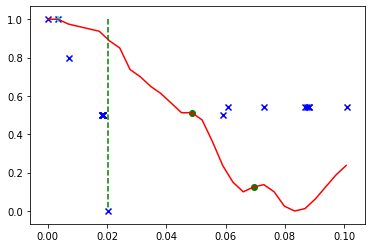

[0.125  0.5125]
[0.15625002 0.20208337]
[0.06944444 0.04861111]


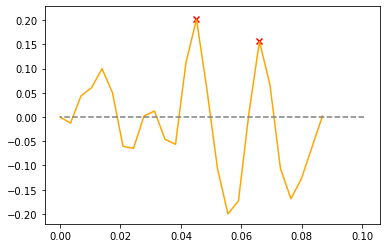

27.600000565499077
0.020833332906477153


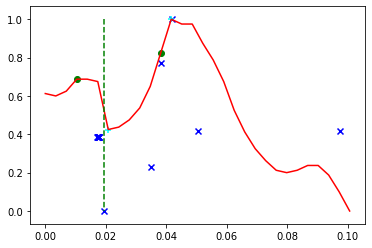

[0.6875 0.825 ]
[0.3645833  0.37083333]
[0.01041667 0.03819444]


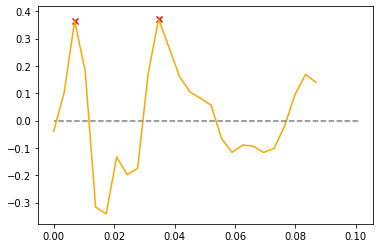

19.591836401046894
0.0243055559694767


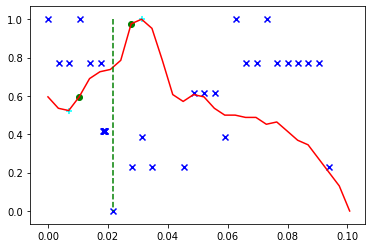

[0.5952381  0.97619048]
[0.12301586 0.44841273]
[0.01041667 0.02777778]


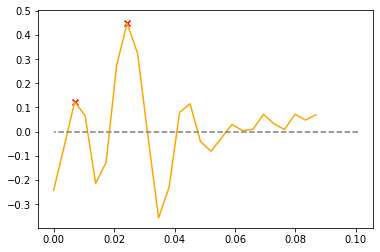

0.0
0.0


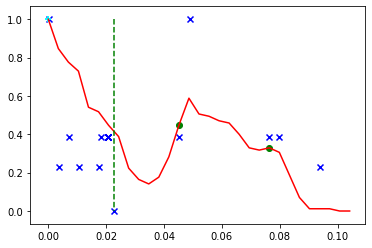

[0.32941176 0.44705882]
[0.22352944 0.3882353 ]
[0.07638889 0.04513889]


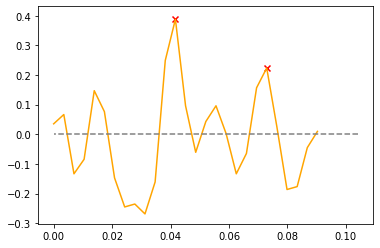

12.52881343797102
0.05208333383779973


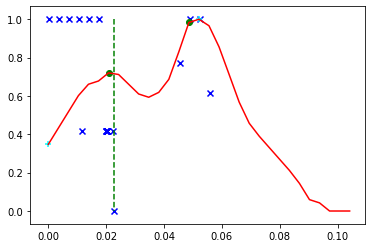

[0.72033898 0.98305085]
[0.13559322 0.3262712 ]
[0.02083333 0.04861111]


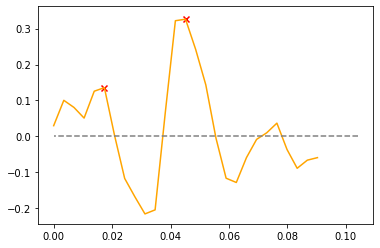

0.0
0.0


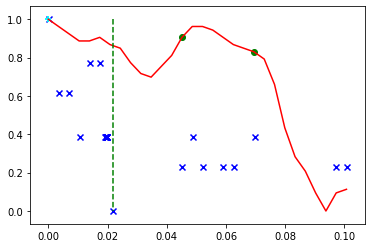

[0.90566038 0.83018868]
[0.17295597 0.31761012]
[0.04513889 0.06944444]


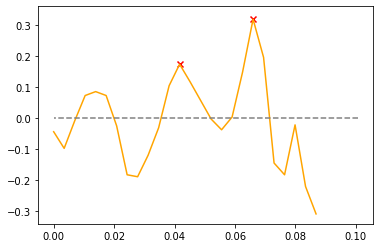

0.0
0.0


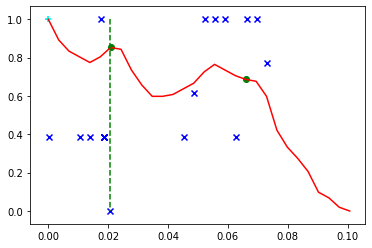

[0.85294118 0.68627451]
[0.22058821 0.24183003]
[0.02083333 0.06597222]


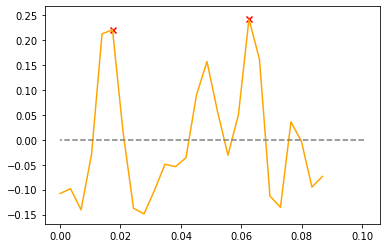

0.0
0.0


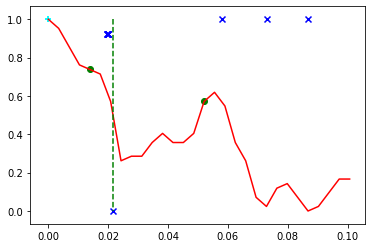

[0.73809524 0.57142857]
[0.43253961 0.49603179]
[0.01388889 0.05208333]


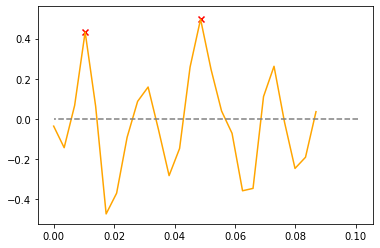

6.646153701137708
0.02430555608589202


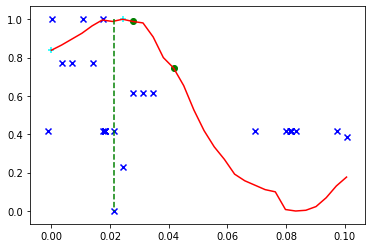

[0.74615385 0.98846154]
[0.08525645 0.16730769]
[0.04166667 0.02777778]


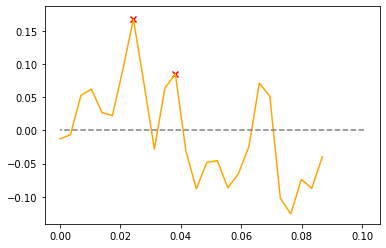

7.419847552828096
0.027777776937000453


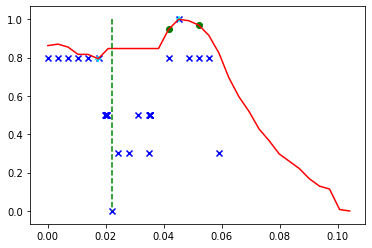

[0.96946565 0.94656489]
[0.15139949 0.18575063]
[0.05208333 0.04166667]


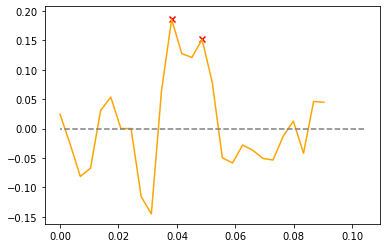

48.000000983476646
0.020833332906477153


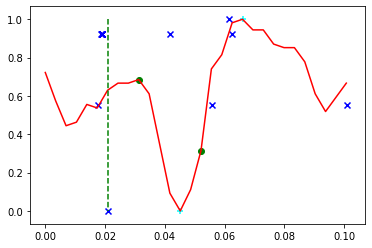

[0.31481481 0.68518519]
[0.37345675 0.4629629 ]
[0.05209491 0.03126157]


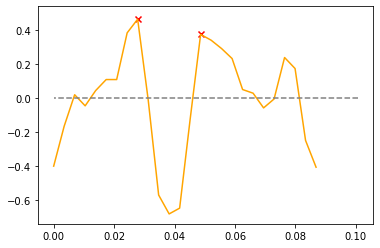

11.075503122936592
0.09028935199603438


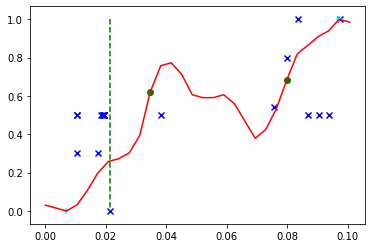

[0.68181818 0.62121212]
[0.19696971 0.42171716]
[0.07987268 0.0347338 ]


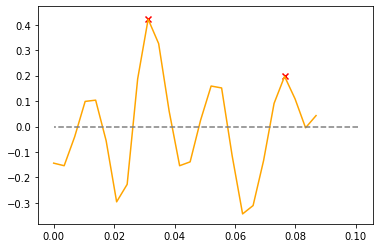

0.0
0.0


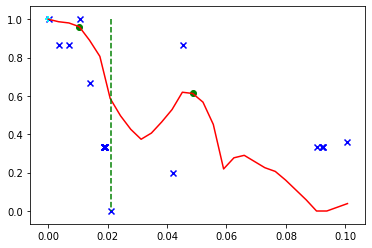

[0.96129032 0.61290323]
[0.23548392 0.31612897]
[0.01041667 0.04861111]


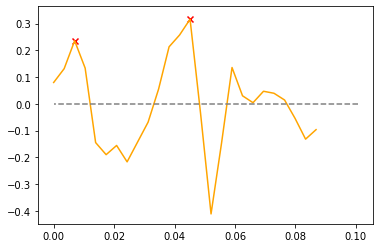

17.791505871986857
0.0486111108912155


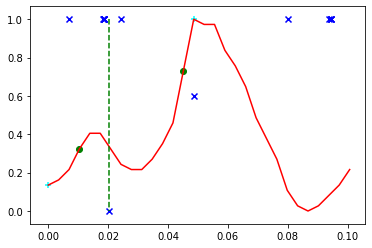

[0.32432432 0.72972973]
[0.28378378 0.56306306]
[0.01041667 0.04513889]


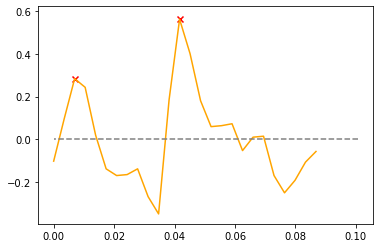

41.14285644219847
0.0243055559694767


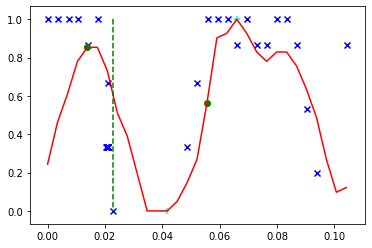

[0.85365854 0.56097561]
[0.43089436 0.5284553 ]
[0.01388889 0.05555555]


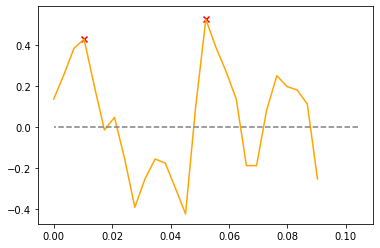

22.377797857859548
0.013912037131376565


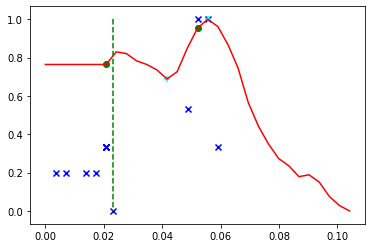

[0.76415094 0.95283019]
[0.11792453 0.2928931 ]
[0.02083333 0.05210648]


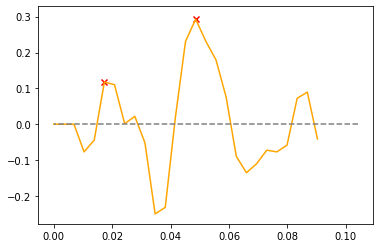

7.058823240153938
0.010416667093522847


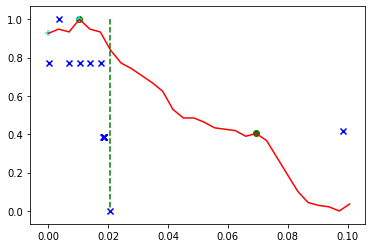

[1.         0.40441176]
[0.1384804 0.1544118]
[0.01041667 0.06944444]


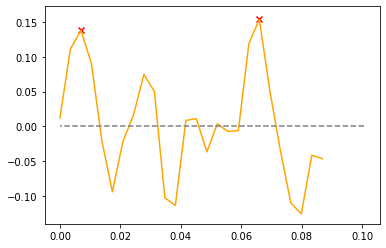

0.0
0.0


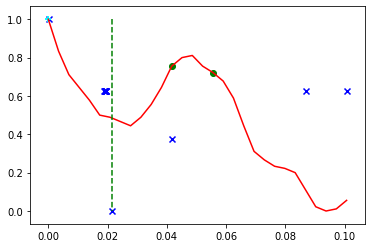

[0.72222222 0.75555556]
[0.16481484 0.21111112]
[0.05555556 0.04166667]


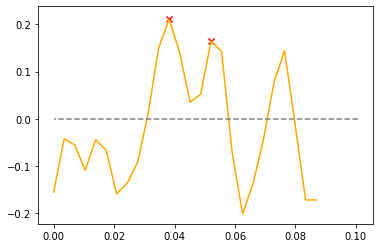

9.931034523581777
0.1006944440305233


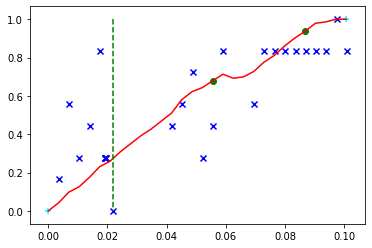

[0.93706294 0.67832168]
[0.05477855 0.07925408]
[0.08680556 0.05555556]


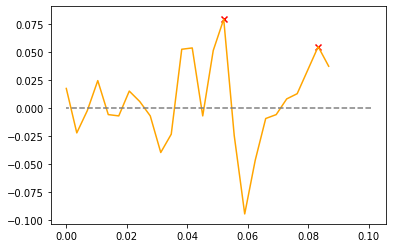

22.153846160194576
0.04513888887595385


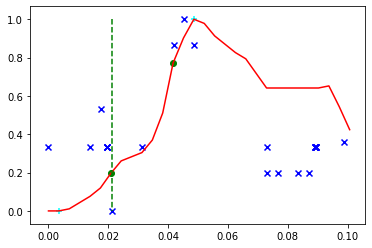

[0.19565217 0.77173913]
[0.09782609 0.33514492]
[0.02083333 0.04166667]


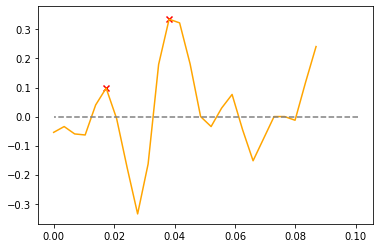

46.00000222772371
0.010416666162200272


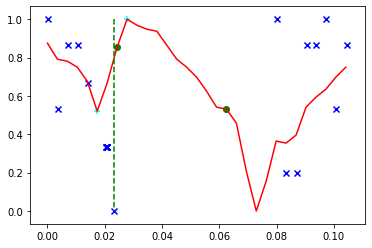

[0.53125    0.85416667]
[0.36805562 0.38368055]
[0.0625     0.02430556]


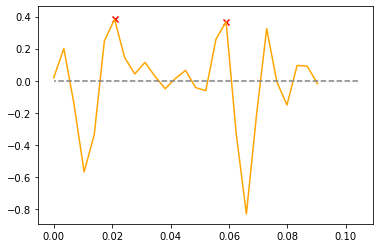

45.63318359423611
0.020844907965511084


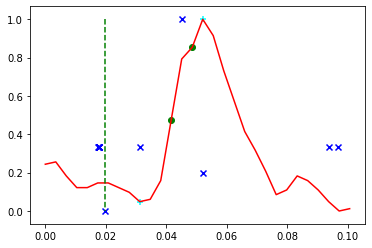

[0.47560976 0.85365854]
[0.41296036 0.49231711]
[0.04166667 0.04862269]


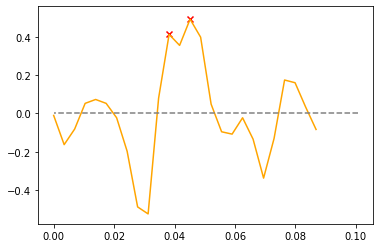

16.93785528112112
0.059039351996034384


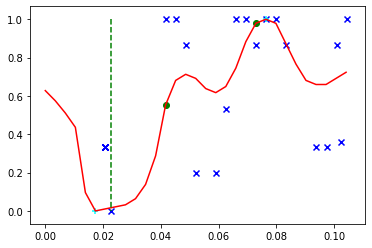

[0.9787234  0.55319149]
[0.25886527 0.39184397]
[0.07292824 0.04167824]


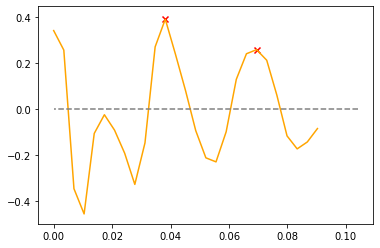

39.8833827732107
0.024305555038154125


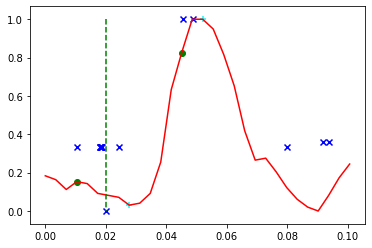

[0.15306122 0.82653061]
[0.08503402 0.42687076]
[0.01041667 0.04513889]


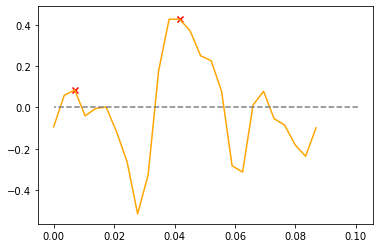

47.249998327810374
0.02083333407063037


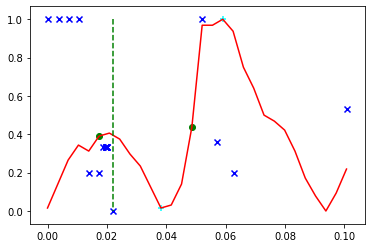

[0.390625 0.4375  ]
[0.21093749 0.79166667]
[0.01736111 0.04861111]


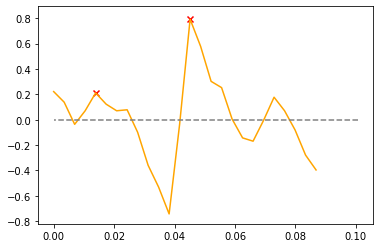

7.874999941326678
0.013888888992369175


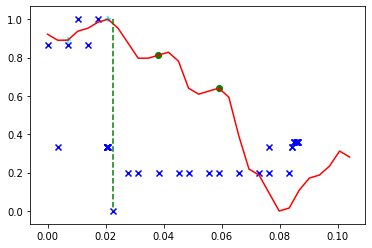

[0.8125   0.640625]
[0.23437497 0.33854162]
[0.03819445 0.05902778]


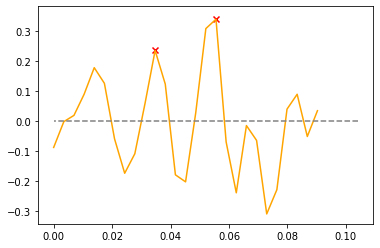

45.303371360328775
0.017361110891215503


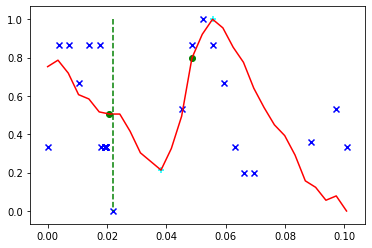

[0.50561798 0.79775281]
[0.19475653 0.41385769]
[0.02083333 0.04861111]


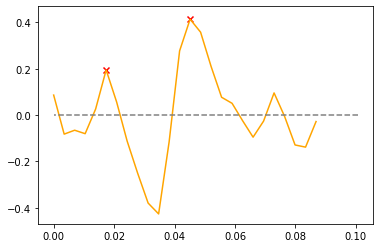

40.21132072475719
0.017361111124046147


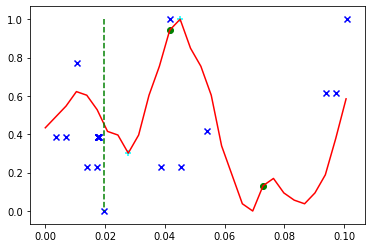

[0.13207547 0.94339623]
[0.27672955 0.48113205]
[0.07291667 0.04166667]


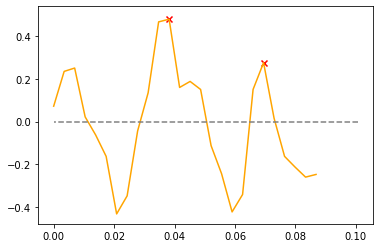

37.28571369538882
0.013888889108784497


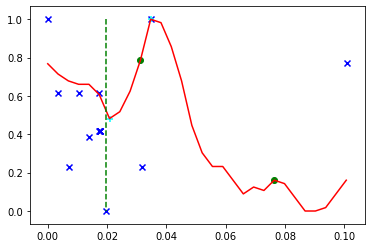

[0.16071429 0.78571429]
[0.1785714  0.53571427]
[0.07638889 0.03125   ]


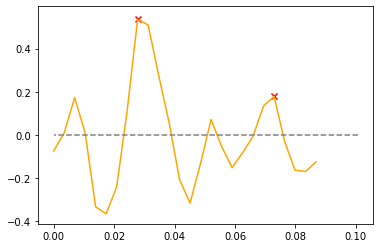

26.1659597559479
0.03821759298443794


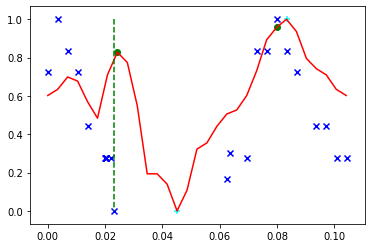

[0.95698925 0.82795699]
[0.32437276 0.66666657]
[0.07988426 0.02430556]


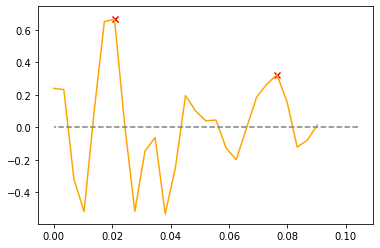

28.48351651004382
0.013888888875953853


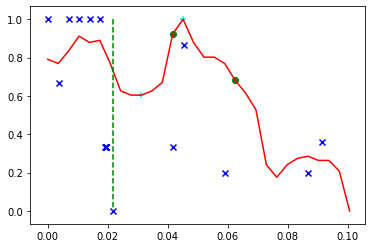

[0.68131868 0.92307692]
[0.2527473 0.5201465]
[0.0625     0.04166667]


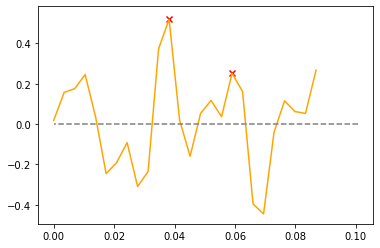

35.77639844847023
0.024305554921738803


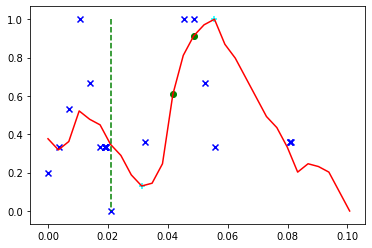

[0.91304348 0.60869565]
[0.28743961 0.41304346]
[0.04864583 0.04170139]


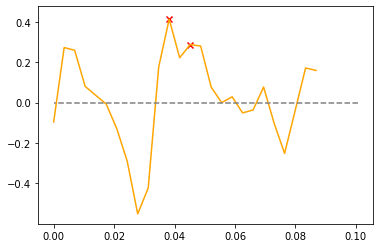

56.639999957799915
0.017361111124046147


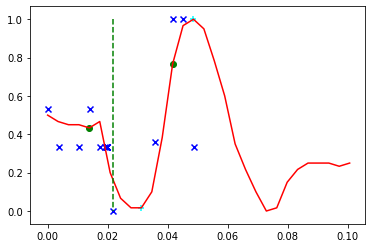

[0.43333333 0.76666667]
[0.39444437 0.61388889]
[0.01390046 0.04167824]


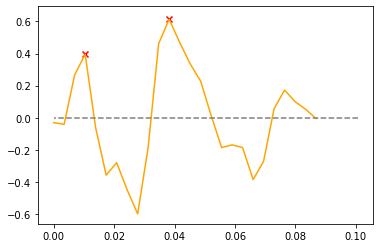

41.14285624513823
0.02430555608589202


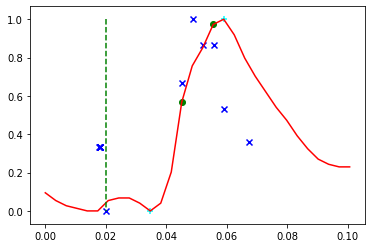

[0.56756757 0.97297297]
[0.3333333  0.35810814]
[0.04515046 0.05556713]


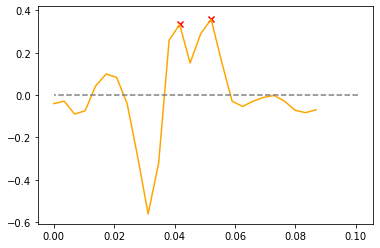

0.0
0.0


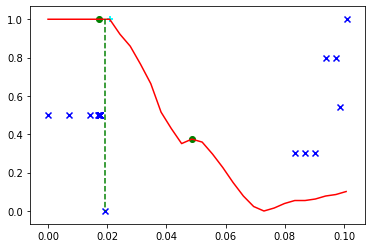

[1.    0.375]
[0.13802082 0.14135543]
[0.01736111 0.04861111]


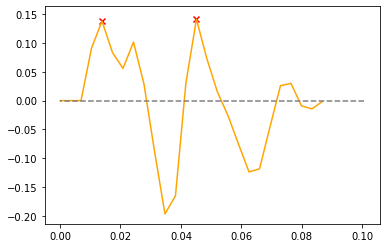

37.953488598313434
0.017361111007630825


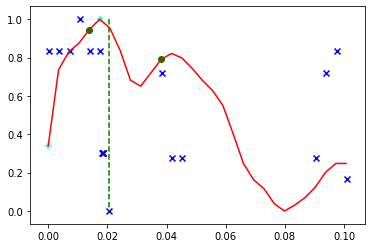

[0.79069767 0.94573643]
[0.18346254 0.29844959]
[0.03819444 0.01388889]


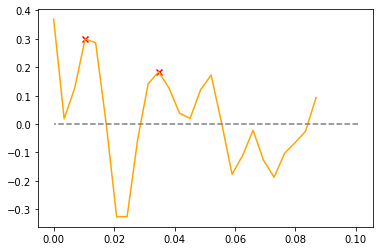

7.6011452006627875
0.03126157389488071


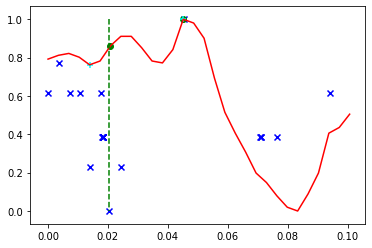

[0.86138614 1.        ]
[0.1980198  0.44719476]
[0.02084491 0.04515046]


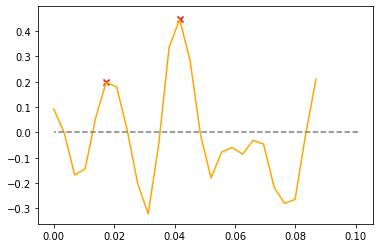

0.0
0.0


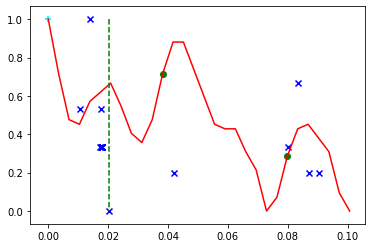

[0.28571429 0.71428571]
[0.42063492 0.57142859]
[0.07987268 0.03820602]


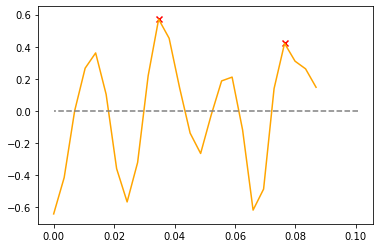

27.670588214677903
0.017361111124046147


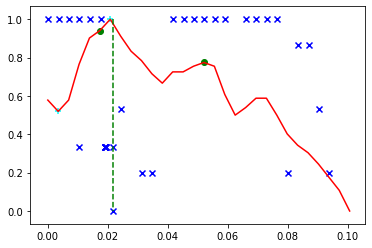

[0.7745098  0.94117647]
[0.24879085 0.26307193]
[0.05208333 0.01736111]


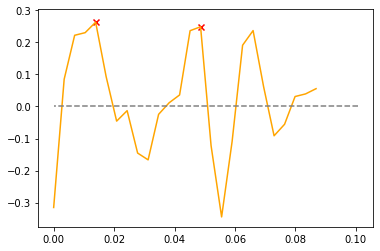

26.18181782714592
0.038194444961845875


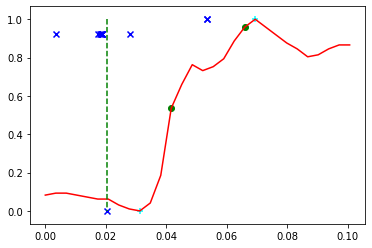

[0.95876289 0.53608247]
[0.1958763  0.42439862]
[0.0659838  0.04167824]


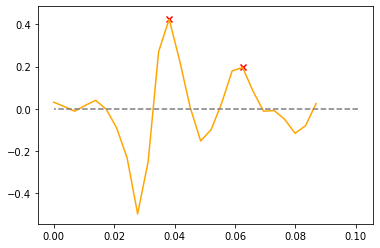

31.964482969220775
0.02085648209322244


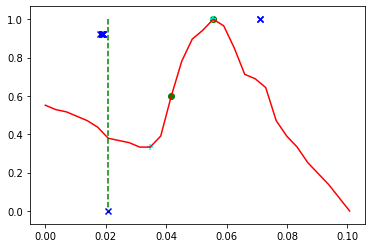

[0.59770115 1.        ]
[0.24084289 0.27969353]
[0.04166667 0.0555787 ]


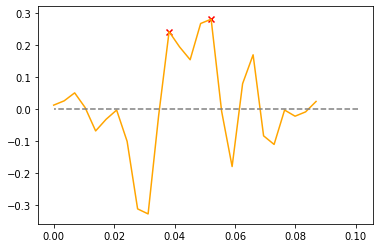

10.285714332242401
0.0486111108912155


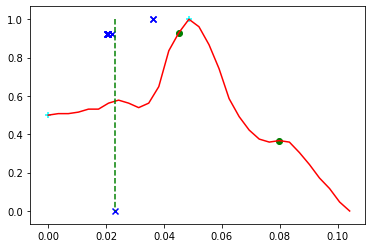

[0.3671875 0.9296875]
[0.11848959 0.3059896 ]
[0.07986111 0.04513889]


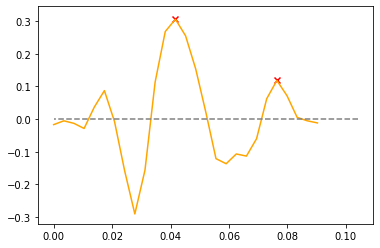

31.964484099196543
0.0312847220338881


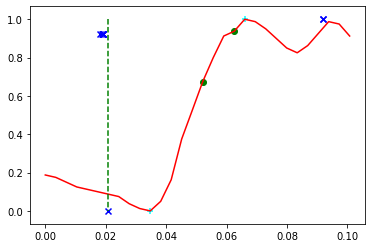

[0.9375 0.675 ]
[0.14166667 0.15208335]
[0.06253472 0.05211806]


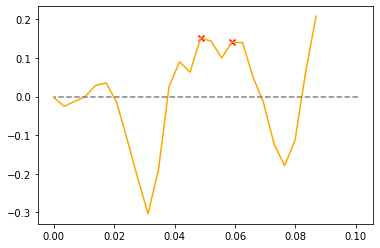

9.597867123604
0.10418981499969959


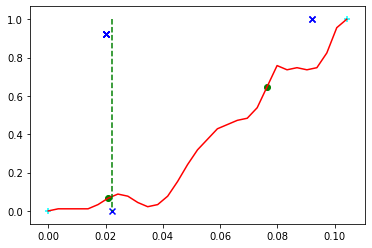

[0.06593407 0.64835165]
[0.10256411 0.22527473]
[0.02083333 0.07641204]


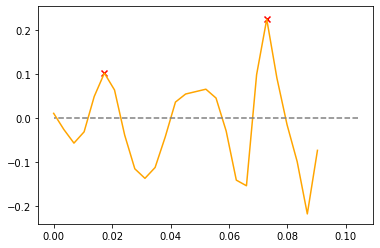

9.240642262015118
0.0069444440305233


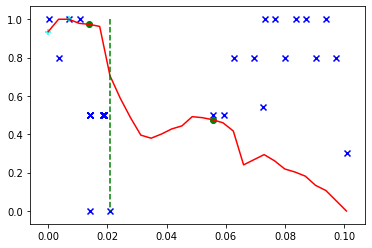

[0.47593583 0.97326203]
[0.21479504 0.33511578]
[0.05555556 0.01388889]


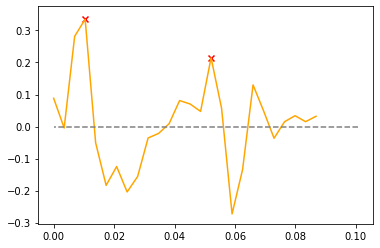

16.94117671189424
0.059027776937000453


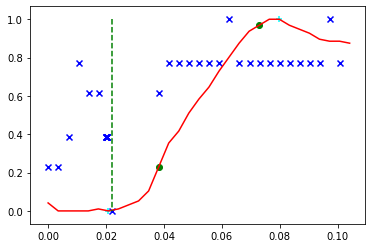

[0.22916667 0.96875   ]
[0.08854164 0.09895833]
[0.03819444 0.07291667]


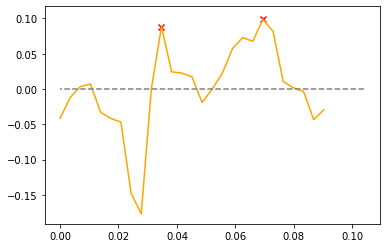

5.877551567797879
0.0034722218988463283


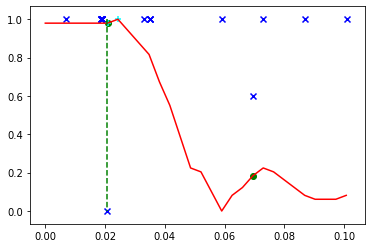

[0.97959184 0.18367347]
[0.14285716 0.16666668]
[0.02083333 0.06944444]


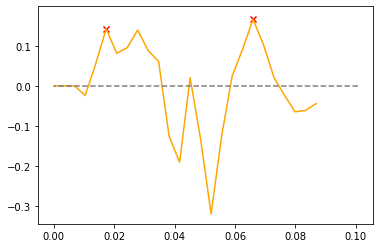

22.15384616019458
0.04513888887595385


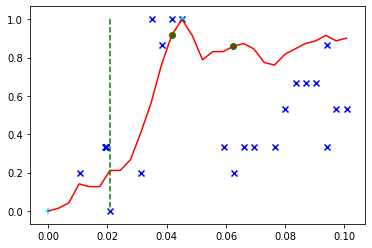

[0.85915493 0.91549296]
[0.14788731 0.45774651]
[0.0625     0.04166667]


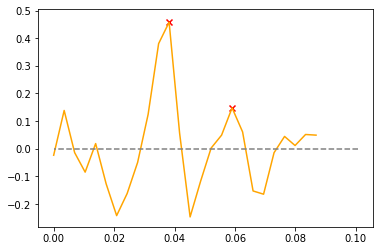

19.200000157356264
0.05208333290647715


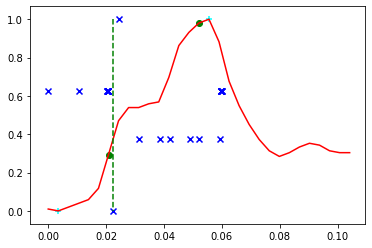

[0.29411765 0.98039216]
[0.29575164 0.4068627 ]
[0.02083333 0.05208333]


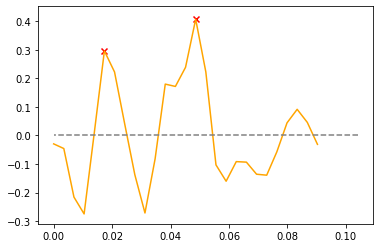

47.94672445383116
0.02085648209322244


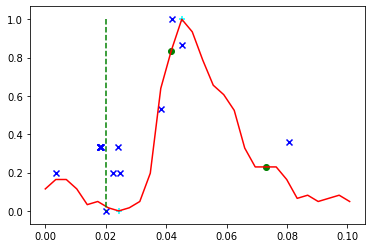

[0.2295082  0.83606557]
[0.16939893 0.58743173]
[0.07293981 0.04168981]


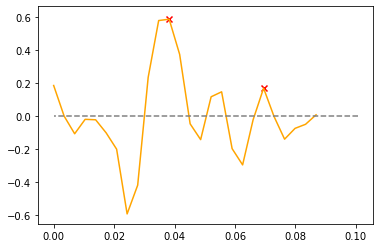

14.436061711388325
0.05210648197680712


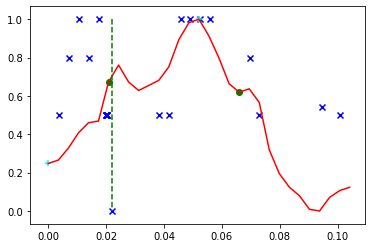

[0.61946903 0.67256637]
[0.32153397 0.41740415]
[0.06599537 0.02083333]


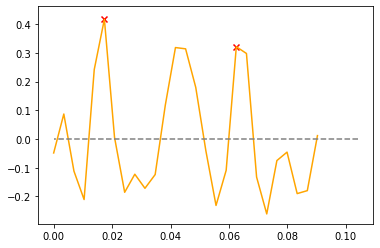

11.996667671838651
0.08335648092906922


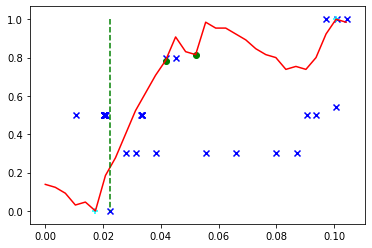

[0.81538462 0.78461538]
[0.17948717 0.2820513 ]
[0.05208333 0.04166667]


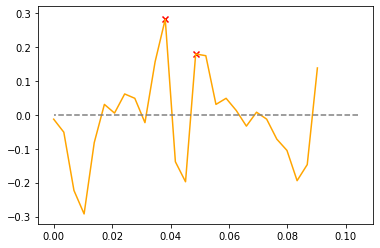

0.0
0.0


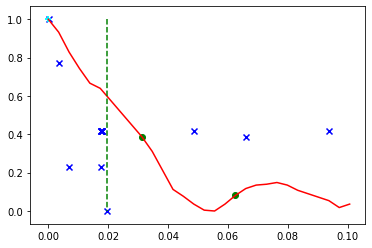

[0.38738739 0.08108108]
[0.05855855 0.06081081]
[0.03126157 0.06251157]


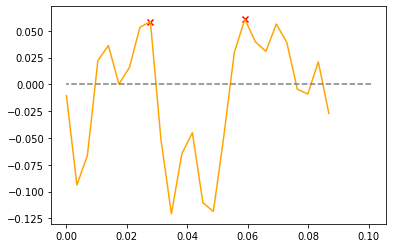

13.712109142451567
0.07292824098840356


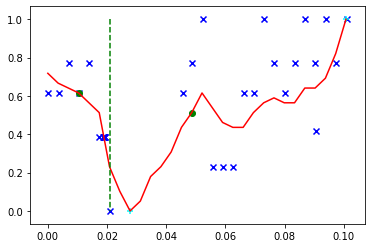

[0.61538462 0.51282051]
[0.29487174 0.33333336]
[0.01041667 0.04861111]


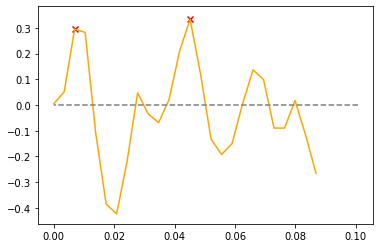

14.89655171303914
0.017361111124046147


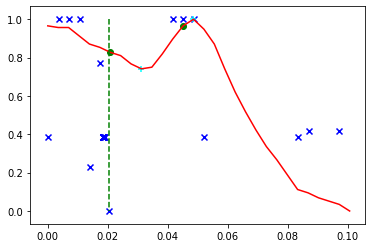

[0.82758621 0.96551724]
[0.02298852 0.23706895]
[0.02083333 0.04513889]


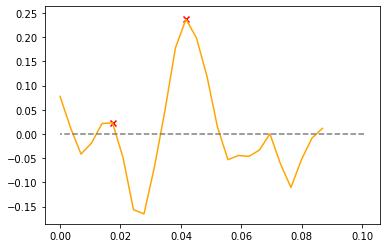

0.0
0.0


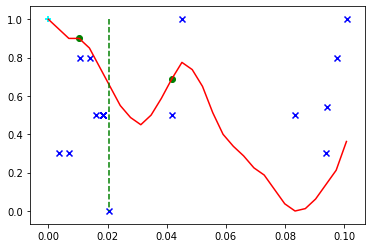

[0.9    0.6875]
[0.14999998 0.32083331]
[0.01041667 0.04166667]


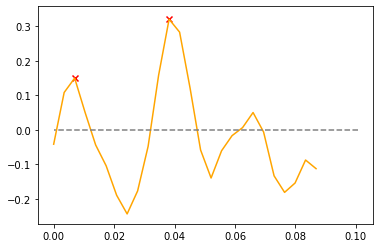

0.0
0.0


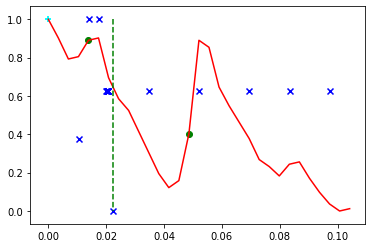

[0.8902439  0.40243902]
[0.39837391 1.004065  ]
[0.01388889 0.04861111]


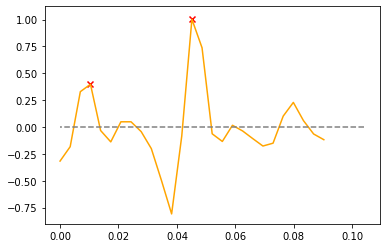

38.13698708276227
0.020833332906477153


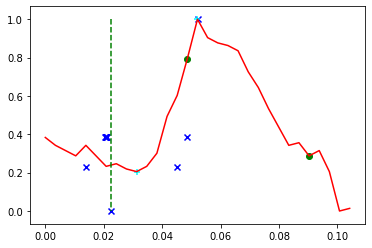

[0.28767123 0.79452055]
[0.28995435 0.50913241]
[0.09027778 0.04861111]


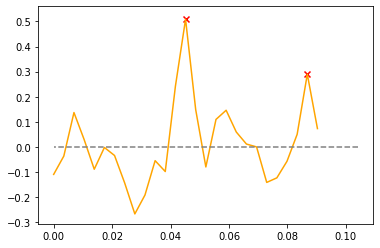

41.142856245138226
0.02430555608589202


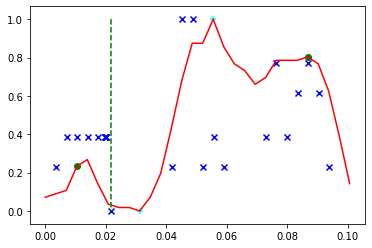

[0.80357143 0.23214286]
[0.37202376 0.38988091]
[0.08680556 0.01041667]


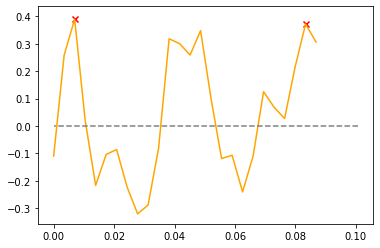

In [77]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    print(slopes[i])
    print(time_diffs[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    plt.scatter(peak_times[i], peak_values[i], marker='o', c='green')
    plt.scatter(cgmSeries_np[i][maxs[i]], cgmNorm_np[i][maxs[i]], marker='+', c='cyan')
    plt.scatter(cgmSeries_np[i][mins[i]], cgmNorm_np[i][mins[i]], marker='+', c='cyan')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()
    print(peak_values[i])
    print(peak_heights[i])
    print(peak_times[i])
    plt.figure()
    plt.plot(cgmSeries_np[i][reg_window_size:], reg_errors[i], c='orange')
    plt.plot(cgmSeries_np[i], np.zeros(len(cgmSeries_np[i])), c='gray', linestyle='dashed')
    plt.scatter(peak_time_diffs[i], peak_heights[i], c='red', marker='x')
    plt.show()    

# 1.b Vedant Features

In [78]:
# Windowed features
window_mins = []
window_maxs = []
window_means = []
window_vars = []
for i in range(0, len(cgmSeries_np)):
    window_input = DataFrame(cgmNorm_np[i][::-1])
    width=5
    shifted=window_input.shift(width - 1)
    window=shifted.rolling(window=width)
    dataframe=concat([window.var(), window.min(),  window.mean(), window.max() ], axis=1)
    dataframe.columns = ['var', 'min', 'mean', 'max']
    window_features = dataframe.nlargest(2,'var')
    window_values = window_features.values
    window_mins.append([window_values[0][1], window_values[1][1]])
    window_maxs.append([window_values[0][3], window_values[1][3]])
    window_vars.append([window_values[0][0], window_values[1][0]])
    window_means.append([window_values[0][2], window_values[1][2]])

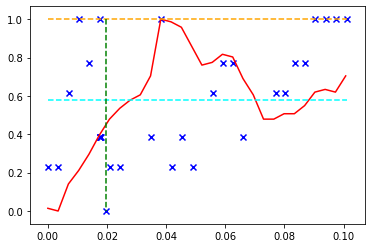

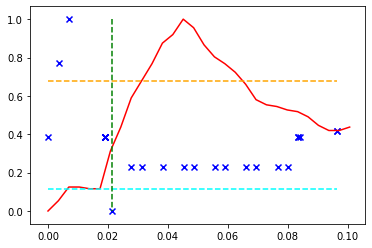

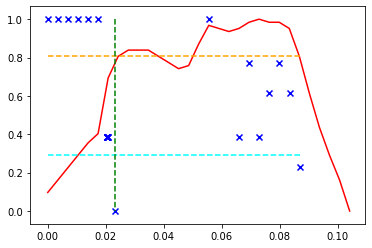

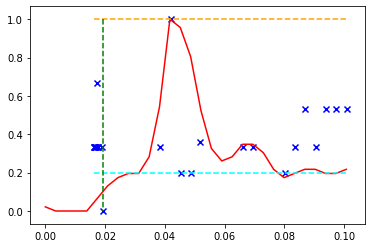

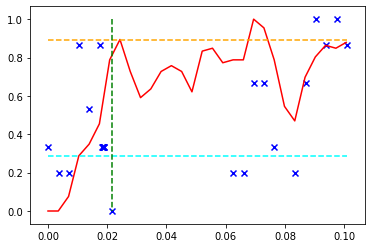

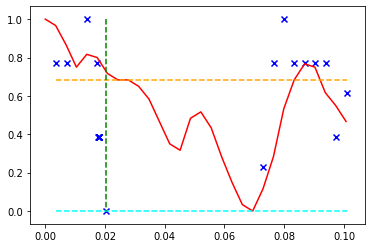

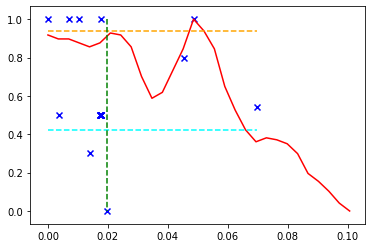

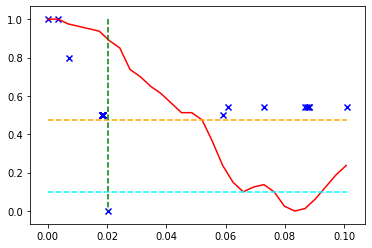

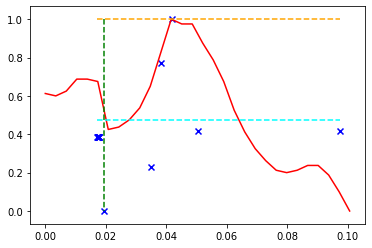

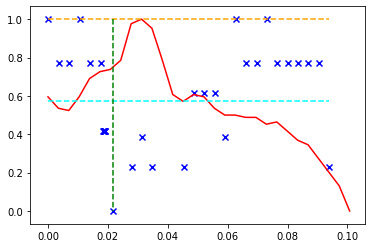

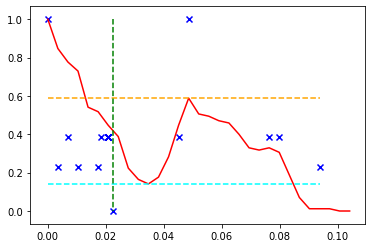

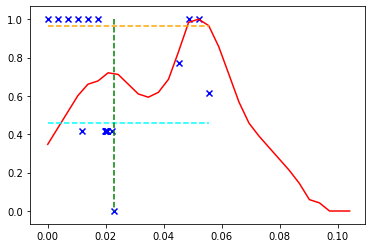

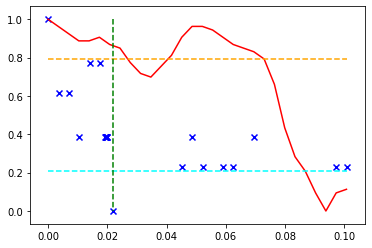

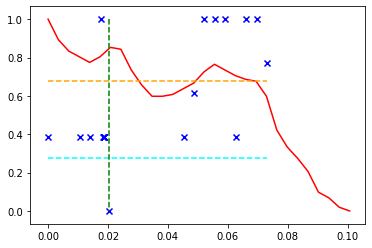

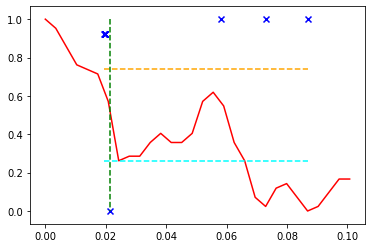

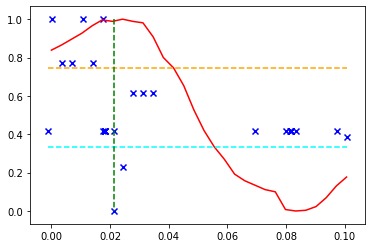

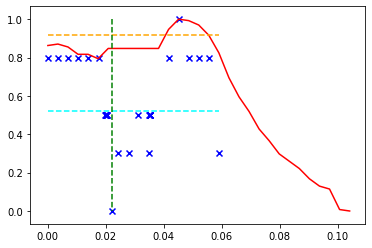

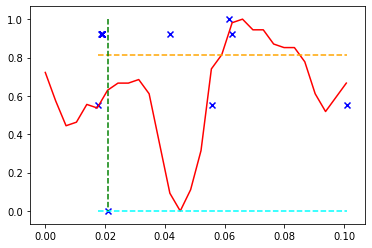

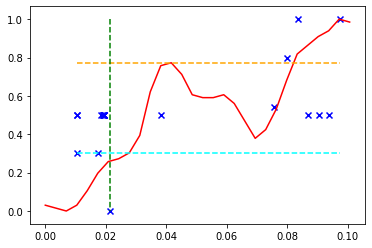

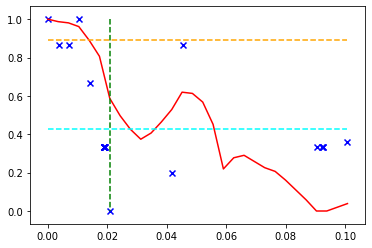

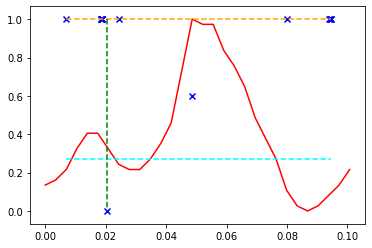

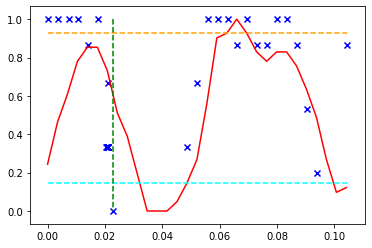

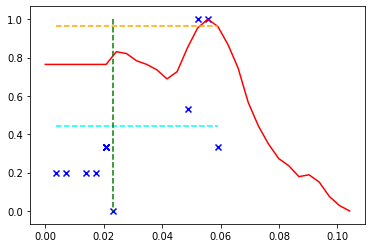

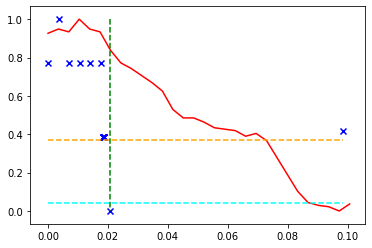

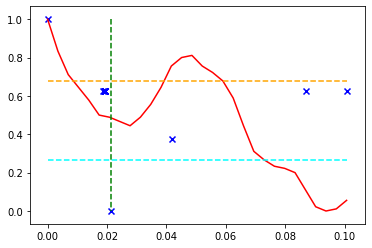

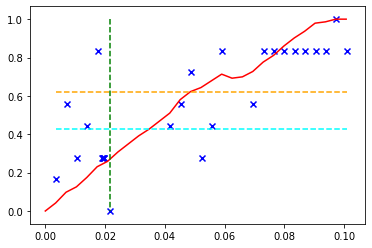

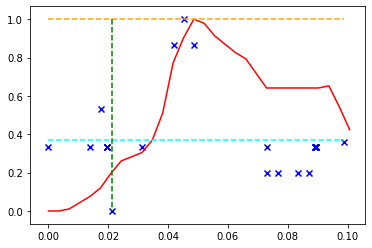

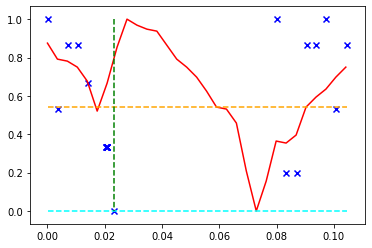

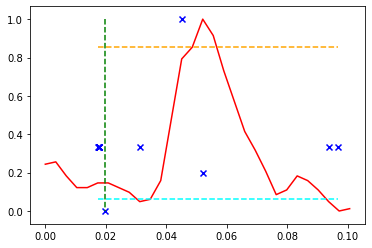

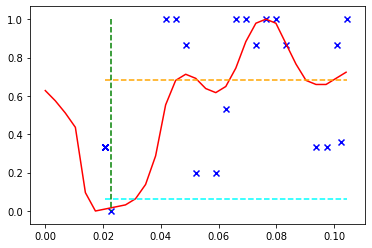

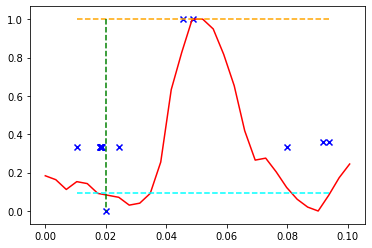

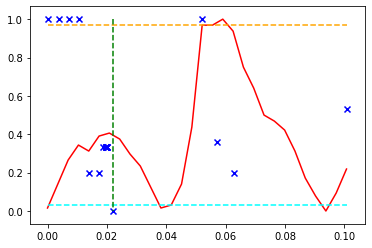

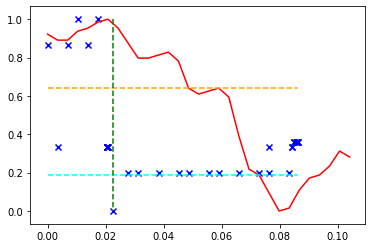

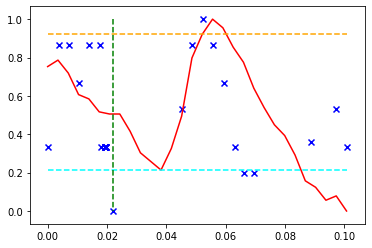

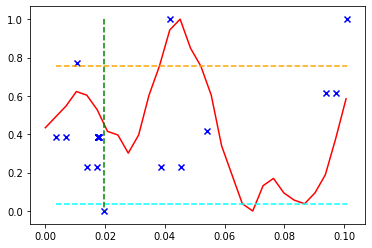

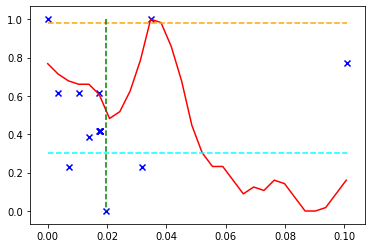

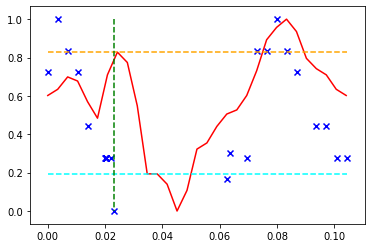

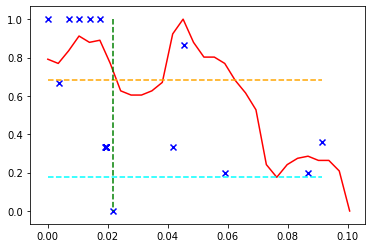

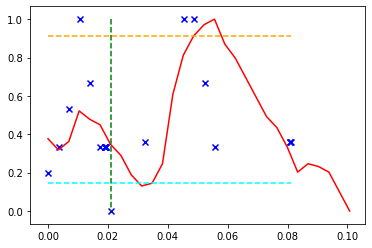

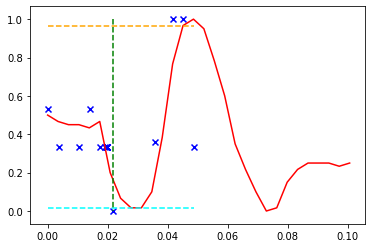

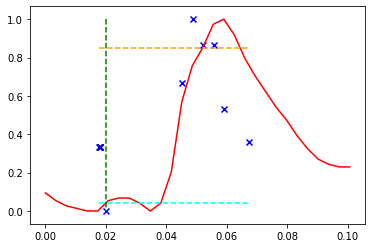

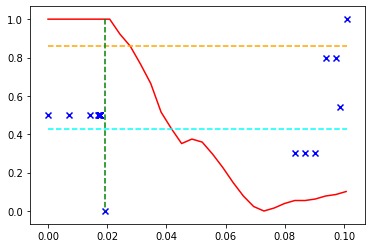

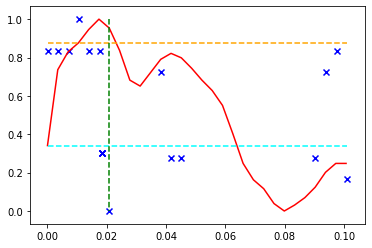

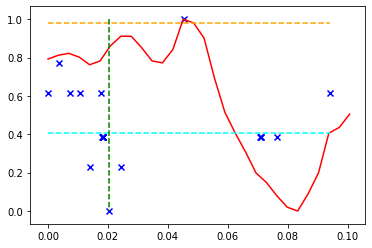

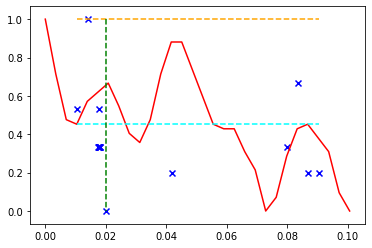

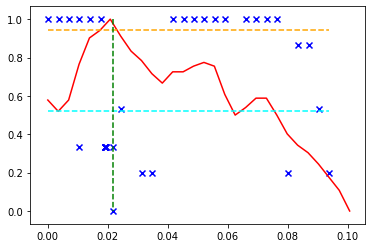

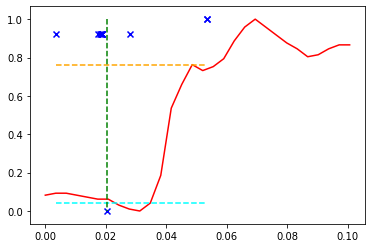

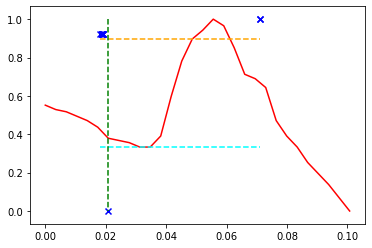

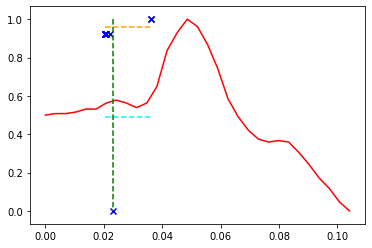

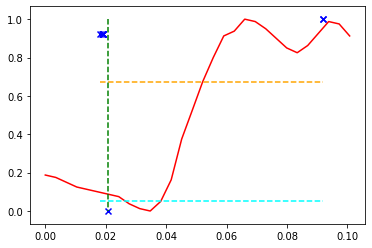

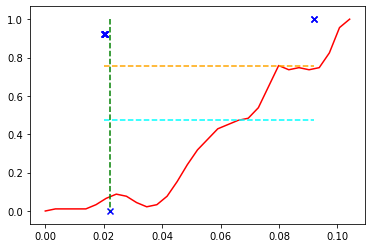

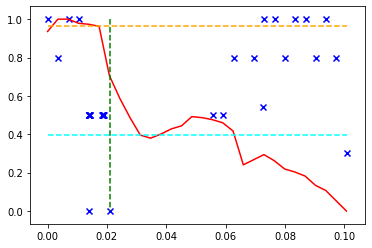

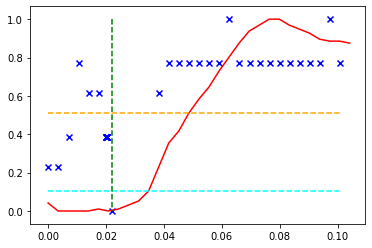

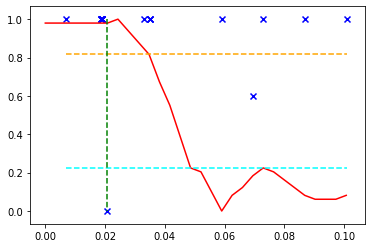

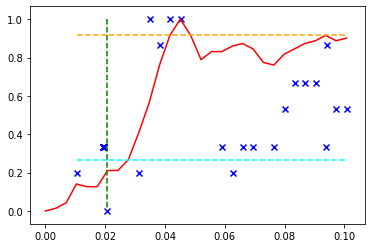

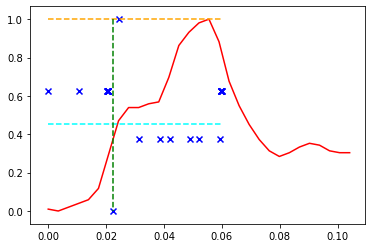

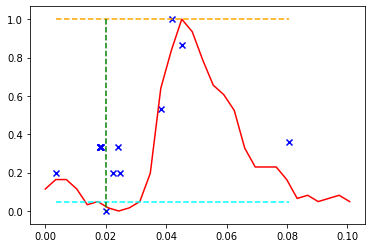

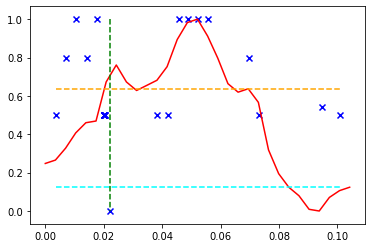

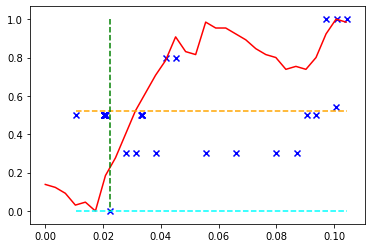

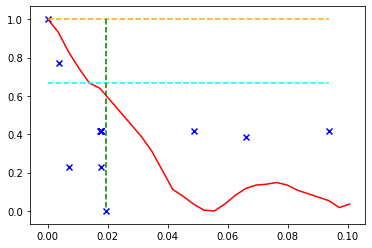

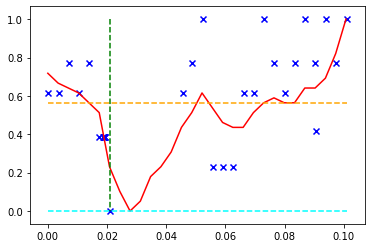

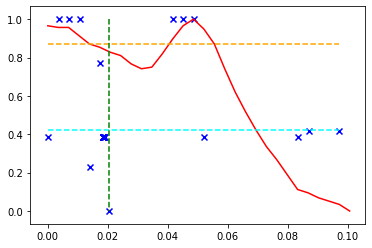

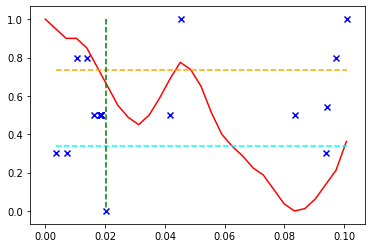

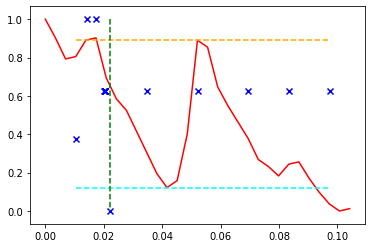

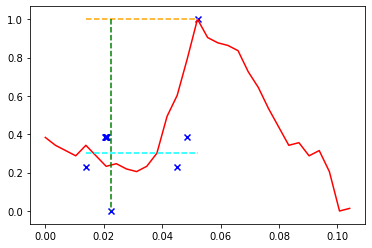

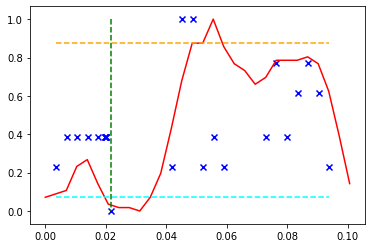

In [79]:
# Visualize
for i in range(0, len(cgmSeries_np)):
    plt.figure()
    plt.plot(cgmSeries_np[i], cgmNorm_np[i], c='red')
    plt.scatter(insulinTime_np[i], insulinBasalNorm_np[i], marker='x', c='blue')
    po1 = np.nanmin(insulinTime_np[i])
    po2 = np.nanmax(insulinTime_np[i])
    plt.plot([po1, po2], [window_mins[i][0], window_mins[i][0]], c='cyan', linestyle='dashed')
    plt.plot([po1, po2], [window_maxs[i][0], window_maxs[i][0]], c='orange', linestyle='dashed')
    insulinBolusNon = insulinBolusNorm_np[i]
    insulinTimesNon = insulinTime_np[i]
    insulinTimesNon = insulinTimesNon[np.nonzero(insulinBolusNon)]
    insulinBolusNon = insulinBolusNon[np.nonzero(insulinBolusNon)]
    for j in range(0, len(insulinBolusNon)):
        plt.plot([insulinTimesNon[j], insulinTimesNon[j]], [insulinBolusNon[j], 0], c='green', linestyle='dashed')
    plt.show()

# 1.c Omkar Features

In [80]:
# series = cgmNorm_np
# datenum = cgmSeries_np
# InsulinBolus = insulinBolusNorm_np
# InsulinTimestamp = insulinTime_np

In [81]:
maximum=[]
for i in range(insulinBolusNorm_np[:,0].size):
    maximum.append(np.nanargmax(insulinBolusNorm_np[i]))

In [82]:
def slope(time,values):
    slope = []
    for i in range(len(values)-1):
        slope.append((values[i+1]-values[i])/(time[i+1]-time[i])) 
    slope.append(np.nan)
    slope = np.asarray(slope)
    
    return slope

(array([10]),)
0.4605410239213058


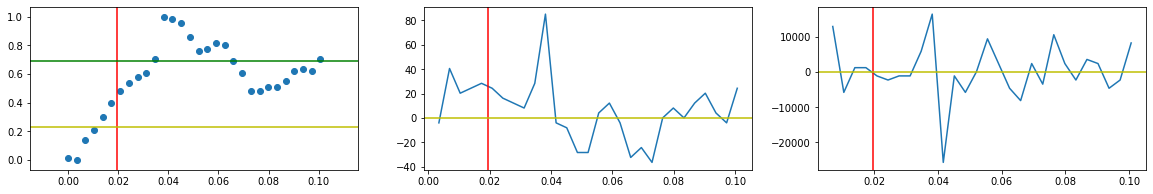

(array([13]),)
0.39384920634920634


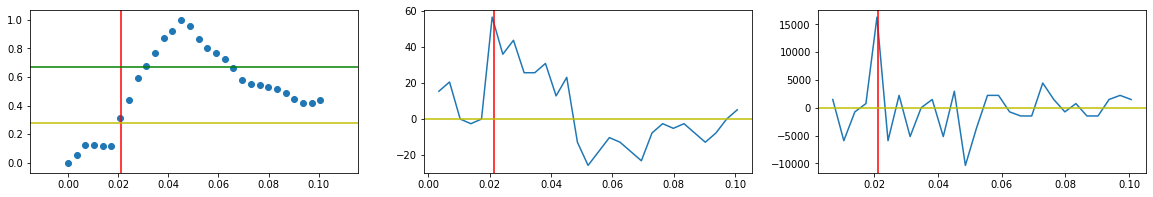

(array([14]),)
0.239089184060721


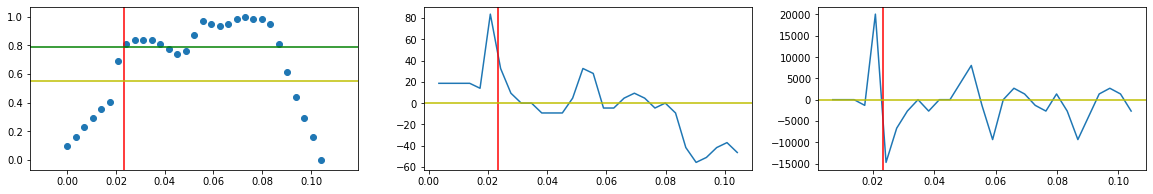

(array([10]),)
0.3247066942719117


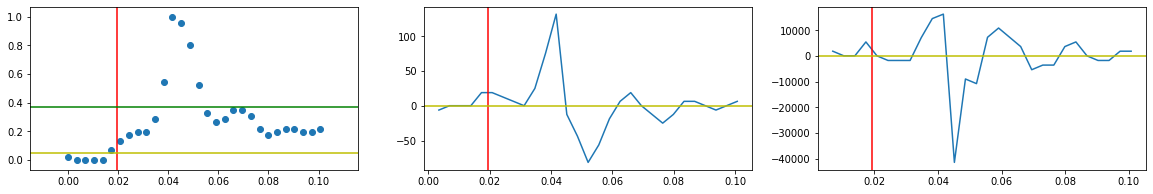

(array([14]),)
0.3455368161250513


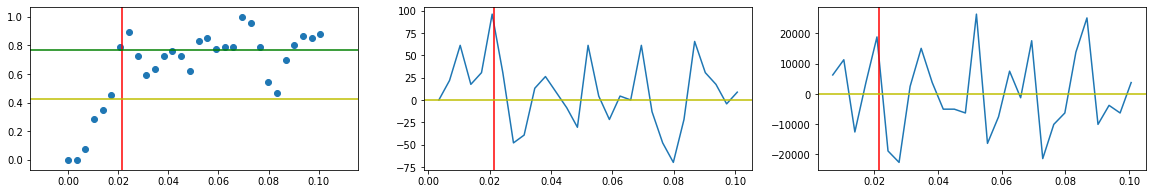

(array([12]),)
-0.3954545454545456


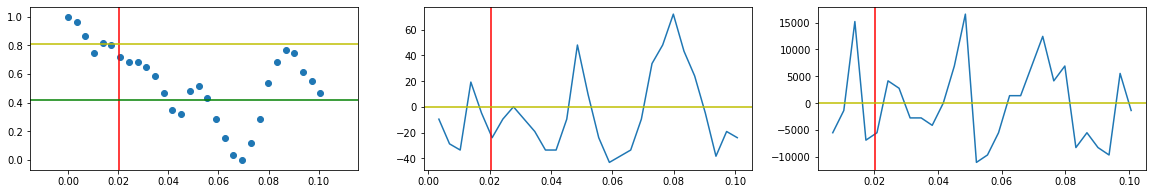

(array([14]),)
-0.35093529878247887


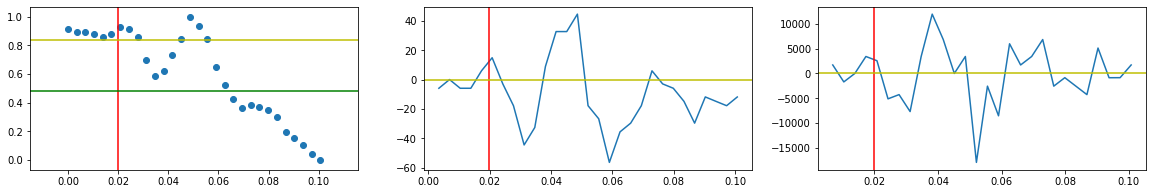

(array([10]),)
-0.6472222222222221


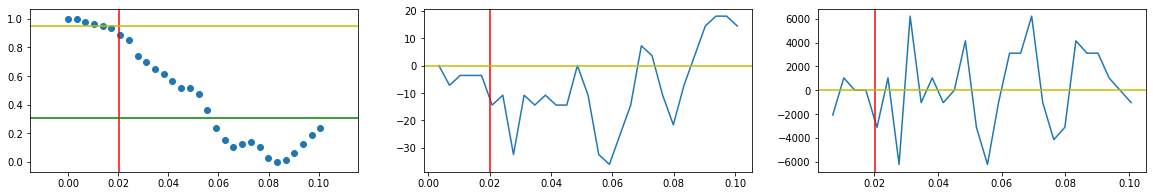

(array([8]),)
-0.14068322981366455


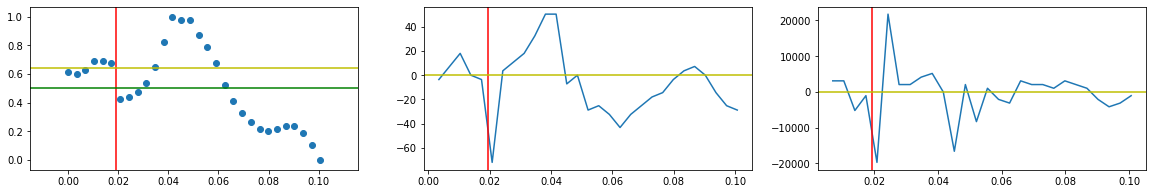

(array([13]),)
-0.26322751322751314


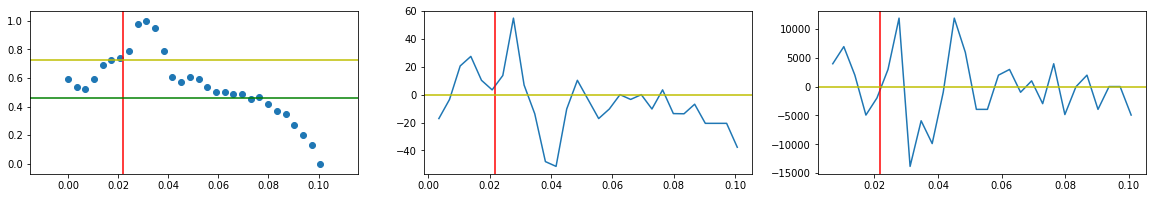

(array([13]),)
-0.20588235294117646


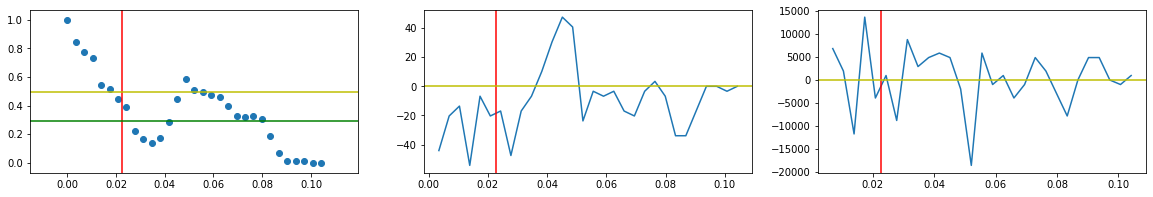

(array([16]),)
-0.24293785310734478


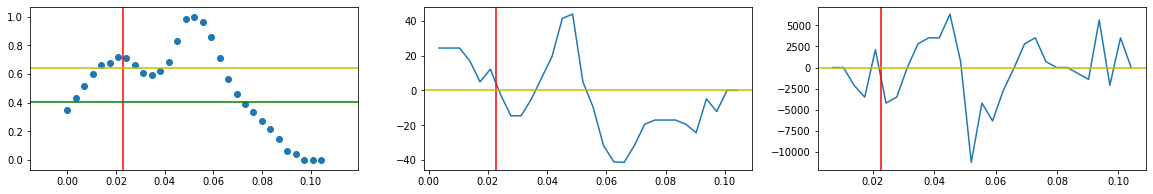

(array([14]),)
-0.2398190045248868


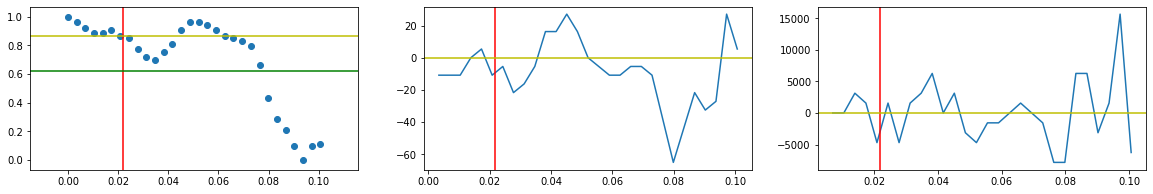

(array([9]),)
-0.3402406417112299


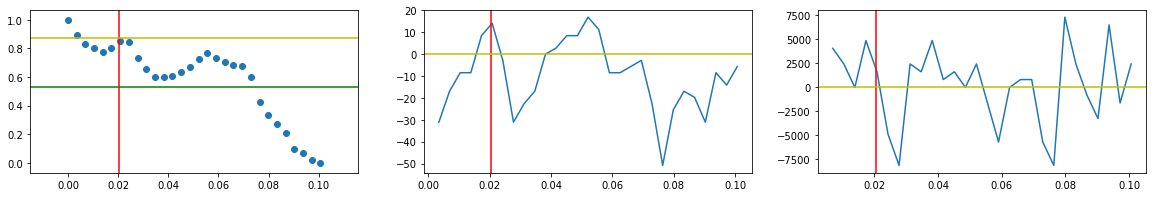

(array([6]),)
-0.6019047619047617


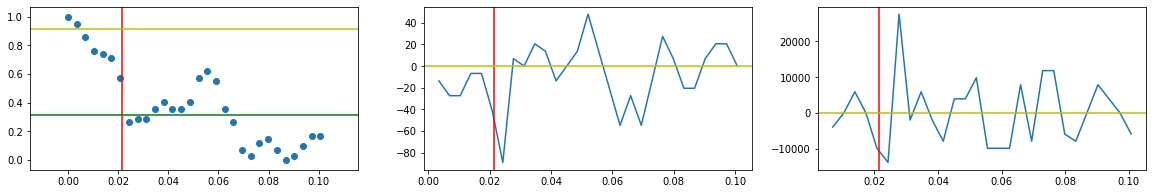

(array([12, 13]),)


TypeError: only size-1 arrays can be converted to Python scalars

<Figure size 1440x216 with 0 Axes>

In [84]:
mean_before = []
mean_after = []
mean_dif = []
for i in range(0,len(cgmNorm_np)):
    fig = plt.figure(figsize=(20,3))
    
    sl = slope(cgmSeries_np[i],cgmNorm_np[i])
    
    
    sl_1 = slope(cgmSeries_np[i],sl)
    sl_2 = slope(cgmSeries_np[i],sl_1)
    sl_3 = slope(cgmSeries_np[i],sl_2)
    cut = insulinTime_np[i,maximum[i]]
    cut1 = np.where(insulinTime_np[i]== cut)
    print(cut1)
    mean1 = np.nanmean(cgmNorm_np[i][-1:-int(cut1[0]):-1])
    mean2 = np.nanmean(cgmNorm_np[i][-int(cut1[0]):0:-1])
    
    mean_before.append(mean1)
    mean_after.append(mean2)
    
    print(mean2-mean1)
    
    plt.subplot(1,3,1)
    plt.scatter(cgmSeries_np[i],cgmNorm_np[i])
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = mean1,c='y')
    plt.axhline(y = mean2,c='g')
    
    plt.subplot(1,3,2)
    plt.plot(cgmSeries_np[i],sl)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    
    plt.subplot(1,3,3)
    plt.plot(cgmSeries_np[i],sl_1)
    plt.axvline(x=insulinTime_np[i,maximum[i]],c='r')
    plt.axhline(y = 0,c='y')
    plt.show()

mean_dif = [x - y for x, y in zip(mean_after, mean_before)]
print(mean_dif)

# 1.d Ananth Features

In [ ]:
Feature_vector=[]
for i in range(0, len(cgmSeries_np)):
#FFT
    fastfouriertransform=rfft(cgmNorm_np[i])
    plt.figure()
    plt.plot(cgmSeries_np[i], fastfouriertransform, c='red')
    fft_max=np.nanmax(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_max)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='black')
    fft_min=np.nanmin(fastfouriertransform)
    s=np.where(fastfouriertransform == fft_min)
    plt.scatter(cgmSeries_np[i][s],cgmNorm_np[i][s], c='violet')
    fft_mean=np.nanmean(fastfouriertransform)
    fft_variance=np.nanvar(fastfouriertransform)
    Feature_vector.append([fft_max,fft_min,fft_mean,fft_variance])
    plt.show()
    print([fft_max,fft_min,fft_mean,fft_variance])
display(Feature_vector)   

# 2. Generating Feature Matrix, Visualizing Spread and PCA

In [ ]:
# Feature Matrix
matrix = []
for i in range(0, len(cgmSeries_np)):
    matrix_row = np.array([])
    # Anirudh
    matrix_row = np.append(matrix_row, slopes[i])
    matrix_row = np.append(matrix_row, time_diffs[i])
    matrix_row = np.append(matrix_row, peak_values[i])
    matrix_row = np.append(matrix_row, peak_heights[i])
    matrix_row = np.append(matrix_row, peak_times[i])
    # Vedant
    matrix_row = np.append(matrix_row, window_mins[i])
    matrix_row = np.append(matrix_row, window_maxs[i])
    matrix_row = np.append(matrix_row, window_vars[i])
    matrix_row = np.append(matrix_row, window_means[i])
    # Omkar
    matrix_row = np.append(matrix_row, mean_before[i])
    matrix_row = np.append(matrix_row, mean_after[i])
    matrix_row = np.append(matrix_row, mean_dif[i])
    # Ananth
    matrix_row = np.append(matrix_row, Feature_vector[i])
    if len(matrix) == 0:
        matrix = np.array([matrix_row])
    else:
        matrix = np.append(matrix, [matrix_row], axis=0)
       
matrix = np.nan_to_num(matrix)
# Normalizing Values
transformer = pre.FunctionTransformer(np.log1p, validate=True)
matrix = transformer.transform(matrix)
matrix = np.nan_to_num(matrix)

In [ ]:
# Converting to dataframe for easy visualization
columns = ['Slope_minmax', 'TimeDiff_minmax', 
           'PeakVal1_error', 'PeakVal2_error', 'PeakHt1_error', 'PeakHt2_error', 'PeakTime1_error', 'PeakTime2_error', 
           'Min1_window', 'Min2_window', 'Max1_window', 'Max2_window', 'Var1_window', 'Var2_window', 'Mean1_window', 'Mean2_window', 
           'Mean_before', 'Mean_after', 'Mean_diff',
           'Max_fft', 'Min_fft', 'Mean_fft', 'Var_fft'
          ]
feature_df = pd.DataFrame(matrix, columns=columns)
display(feature_df)

In [ ]:
# Scatter Visualization
rows = [i for i in range(len(cgmNorm_np))]
colors = ['red', 'blue', 'green']
markers = ['x', '+', 'o']
for i in range(0, matrix.shape[1]):
    plt.figure()
    plt.scatter(rows, matrix[:, i], color=colors[i%3] ,marker=markers[i%3])
    # plt.show()
    # Save Images
    plt.savefig('Images/Patient' + str(patient) + '/' + columns[i] + '.png')

In [ ]:
# PCA
pca = PCA()
pca.fit(matrix)
components = pca.components_
variances = pca.explained_variance_
x = [i for i in range(0, len(components[0]))]
for i in range(0, 5):
    print(variances[i])
    plt.figure()
    plt.bar(x, components[i])
    plt.xticks(np.arange(len(components[0])), x, rotation=90)
    # plt.show()
    plt.savefig('Images/Patient' + str(patient) + '/' + 'PCA' + str(i) + '.png')
    print(components[i])